In [1]:
##
## FNAL muon g-2 experiment
## compute how much energy a crystal sees in a fill
##

In [2]:
library(repr, quietly=TRUE)
library(ggplot2, quietly=TRUE)
library(scales, quietly=TRUE)
library(RColorBrewer, quietly=TRUE)
library(latex2exp, quietly=TRUE)

library(nlsr)
## library(nlmrt)
library(nloptr)

In [3]:
##
## open graphic device
##

my.width = 6
my.height = 5
my.width.pixels = 560

## smaller plots in notebook
options(repr.plot.width=my.width, repr.plot.height = my.height, repr.plot.res = 64)

rc = try(dev.off(), silent=TRUE)
rc = dev.new(width=my.width, height=my.height, dpi = my.width.pixels / my.width)

##--- plot colors
plot.cols = brewer.pal(8, "Dark2")

In [4]:
##
## plot functions
## see http://t-redactyl.io/blog/2016/03/creating-plots-in-r-using-ggplot2-part-9-function-plots.html
##

##--- configure ggplot2 theme
theme_set(theme_bw(base_size = 15, base_family = "Helvetica"))
theme_update(
  ## plot.title = element_text(face="bold", vjust=1),
  panel.background = element_rect(fill = "transparent",colour = NA),
  plot.background = element_rect(fill = "transparent",colour = NA),
  NULL
)

In [5]:
##
## save last plot
##
save.plot = function(name, plot = last_plot(), width=my.width, height=my.height, horiz.pixels=my.width.pixels) {
  name = paste0("", name)
  dpi = my.width.pixels/my.width
  file.png = paste(name, "png", sep=".")
  ggsave(filename=file.png, width=width, height=height, dpi=dpi, bg = "transparent")
  cat("file", file.png, "produced\n")
  file.pdf = paste(name, "pdf", sep=".")
  ggsave(filename=file.pdf, width=width, height=height, dpi=dpi, bg = "transparent")
  cat("file", file.pdf, "produced\n")
}

In [6]:
##
## parameters for FNAL muon g-2 experiment, from TDR
##

##--- maximum electron energy in mu decay for magic energy muons
mudecay.E.max = 3.094

##--- y = E/Emax threshold for T-method
mudecay.y.thr = 0.6

##--- minimum detectable threshold in calorimeter (GeV)
mudecay.E.detected.min = 25e-3

##--- n. muon decays detected by calorimeter with E / Emax = y > 0.6 to measure omega_a with 100 ppb, T-method
mudecay.sampl.abthr =  (0.0398/100e-9)^2

##--- muon decays per fill, detected by calorimeter with E / Emax = y > 0.6 (from simulation)
mudecay.perfill.abthr = 1.1e3

##--- time when hit rates are reported (start time of T-method fit)
t.method.start.time = 31e-6

##--- muon decay time in lab
mudecay.tau.lab = 64e-6

##--- modules
num.modules = 24
##--- crystals.per.module
crystals.per.module = 54
##--- number of crystals
num.crystal = num.modules * crystals.per.module

##--- required n. of fills for T-method
numfills.sampl.tmeth = mudecay.sampl.abthr / mudecay.perfill.abthr

In [7]:
##
## acceptance as f or y
##
mudecay.accept.nv = function(y) {
  ##--- y replaced by energy in MeV
  y = y*mudecay.E.max*1000

  ##--- no acceptance below 25 MeV
  if ( ! (y>25 && y<mudecay.E.max*1000) ) {
    return(0)
  }
  
  par = numeric(10)
  par[1] =  4.10647e-4 
  par[2] =  8.27328e-4 
  par[3] = -9.66426e-7 
  par[4] =  7.24172e-10 
  par[5] = -2.38441e-13 
  par[6] =  2.90055e-17 
  par[7] =  1.27802e-21
  par[8] = -5.47863e-25
  par[9] =  mudecay.E.max*1000
  par[10] = 8.0975

  Pol = sum(par[1:8] * y^seq(0, 7))
  Pol*(1-exp((y-par[9])/par[10]))
}
mudecay.accept = Vectorize(mudecay.accept.nv)

file mudec-calo-eff-vs-y.png produced
file mudec-calo-eff-vs-y.pdf produced


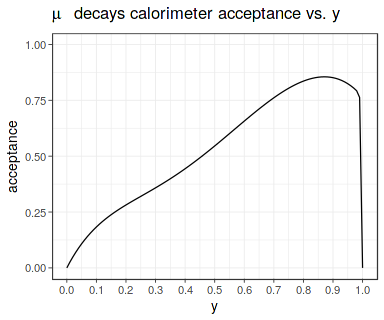

In [8]:
ggplot(data.frame(x = c(0, 1)), aes(x = x)) +
  ggtitle(TeX("$\\mu$ decays calorimeter acceptance vs. y")) +
  stat_function(fun = mudecay.accept) +
  scale_x_continuous(name = "y", breaks=pretty_breaks(10)) +
  scale_y_continuous(name = "acceptance", limits=c(0,1)) +
  NULL
save.plot("mudec-calo-eff-vs-y")

In [9]:
##
## y dependence of electrons from muon decay
##
## N(y) = (y − 1)(4y^2 − 5y − 5) · Acceptance(y)
## A. Fienberg, E989 Note 102, https://gm2-docdb.fnal.gov/cgi-bin/private/ShowDocument?docid=5206
##
## TDR eq. 3.17
## - Ad(E) = Pol * (8y^2 + y + 1) / (4y^2 -5y -y)
## - Nd0(E) propto (y − 1)(4y^2 - 5y - 5)
##
mudecay.y.dep = function(y) {
  (y-1)*(4*y^2-5*y-5)
}

file mudec-distr-vs-y.png produced
file mudec-distr-vs-y.pdf produced


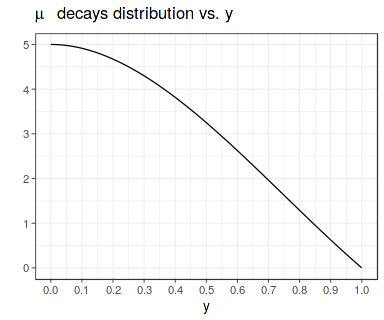

In [10]:
ggplot(data.frame(x = c(0, 1)), aes(x = x)) +
  ggtitle(TeX("$\\mu$ decays distribution vs. y")) +
  stat_function(fun = mudecay.y.dep) +
  scale_x_continuous(name = "y", breaks=pretty_breaks(10)) +
  scale_y_continuous(name = "") +
  NULL
save.plot("mudec-distr-vs-y")

In [11]:
##
## density of detected mu decays (not normalized)
##
mudecay.detected = function(y) {
  rc = mudecay.accept(y) * mudecay.y.dep(y)
  rc
}

file mudec-calo-detected.png produced
file mudec-calo-detected.pdf produced


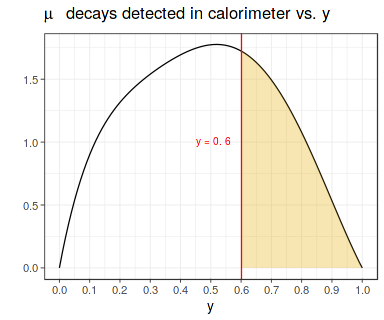

In [12]:
ggplot(data.frame(x = c(0, 1)), aes(x = x)) +
  ggtitle(TeX("$\\mu$ decays detected in calorimeter vs. y")) +
  stat_function(fun = mudecay.detected) +
  stat_function(fun = mudecay.detected, xlim = c(0.6,1), geom = "area", fill=plot.cols[6], alpha=0.3) +
  scale_x_continuous(name = "y", breaks=pretty_breaks(10)) +
  scale_y_continuous(name = "") +
  geom_vline(xintercept=0.6, color="red") +
  annotate("text", label = as.character(TeX("y = 0.6")), x = 0.45, y = 1.0, hjust=0, color="red", parse = T) +
  NULL
save.plot("mudec-calo-detected")

In [13]:
##--- normalization
mudecay.detected.norm = integrate(mudecay.detected, lower=0, upper=1)$value

##--- fraction of detected muon decays above threshold w.r.t. total
mudecay.frac.y.thr = integrate(mudecay.detected, lower=0.6, upper=1)$value / mudecay.detected.norm

##--- fraction of muon decays per fill above 25 MeV
mudecay.frac.E.detected.min =
    integrate(mudecay.detected, lower=mudecay.E.detected.min/mudecay.E.max, upper=1)$value / mudecay.detected.norm

cat("fraction of detected muon decays with y > 0.6:",
    sprintf("%.2f%%", mudecay.frac.y.thr*100))
cat("\n")
cat("fraction of detected muon decays with E > minimum detectable energy:",
    sprintf("%.2f%%", mudecay.frac.E.detected.min*100))
cat("\n")

fraction of detected muon decays with y > 0.6: 32.75%
fraction of detected muon decays with E > minimum detectable energy: 100.00%


In [14]:
##
## hit rates per fill per crystal from simulated hit rates at 31 mus
## TDR p. 531
##

##--- hit rates for 27 crystals, the other 27 crystals have the same rates for symmetry
crystal.hit.rates = 1e3 * c(
  60, 71, 78, 84, 89, 93, 95, 98, 97, 
  269, 280, 255, 240, 225, 208, 188, 174, 158, 
  475, 466, 392, 343, 301, 264, 229, 203, 180
)
crystal.hit.rate.total = 2*sum(crystal.hit.rates)

crystal.hit.rate.mean = crystal.hit.rate.total / crystals.per.module
crystal.hit.rate.max = max(crystal.hit.rates)
crystal.hit.rate.min = min(crystal.hit.rates)

cat(sprintf("total hit rate in whole calorimeter, t > 31 mus, E > 25 MeV: %.2f MHz\n", crystal.hit.rate.total/1e6))

total hit rate in whole calorimeter, t > 31 mus, E > 25 MeV: 11.23 MHz


In [15]:
##
## given exponential decay with some decay time, return how many events happen after a give time
##
decay.exp.fraction.after.time = function(time, decay.time) {
  exp(-time/decay.time)
}

##
## compute num hits per crystal per fill since time=0, given instantaneous rate at time=<time>
## default for t.method start time = 31 mus and muon decay time in lab = 64 mus
##
hits.percrystal.perfill.from.rate.at.time = function(rate, time=t.method.start.time, decay.time=mudecay.tau.lab) {
  rate * decay.time / decay.exp.fraction.after.time(time, decay.time)
}

In [16]:
mudecay.after.t.method.start.time =
  decay.exp.fraction.after.time(time=t.method.start.time, decay.time=mudecay.tau.lab)
cat(sprintf("fraction of muon decays after 31 mus: %.2f%%\n", 100*mudecay.after.t.method.start.time))

fraction of muon decays after 31 mus: 61.61%


In [17]:
##
## hits after 31 mus, correspond to rate as if starting time is time=0
##
cat("hits per crystal per fill after 31 mus, from simulated hit rates: ")
cat(sprintf("%.2f min, %.2f max, %.2f mean\n",
            hits.percrystal.perfill.from.rate.at.time(crystal.hit.rate.min, time=0),
            hits.percrystal.perfill.from.rate.at.time(crystal.hit.rate.max, time=0),
            hits.percrystal.perfill.from.rate.at.time(crystal.hit.rate.mean, time=0)))

hits per crystal per fill after 31 mus, from simulated hit rates: 3.84 min, 30.40 max, 13.31 mean


In [18]:
##
## hits at all times, starting at time=0 requires specificifyng how long after the rate is reported
##
cat("hits per crystal per fill at all times, from simulated hit rates: ")
cat(sprintf("%.2f min, %.2f max, %.2f mean\n",
            hits.percrystal.perfill.from.rate.at.time(crystal.hit.rate.min, time=t.method.start.time),
            hits.percrystal.perfill.from.rate.at.time(crystal.hit.rate.max, time=t.method.start.time),
            hits.percrystal.perfill.from.rate.at.time(crystal.hit.rate.mean, time=t.method.start.time)))

hits per crystal per fill at all times, from simulated hit rates: 6.23 min, 49.34 max, 21.60 mean


file crystal-hit-rate-hottest.png produced
file crystal-hit-rate-hottest.pdf produced


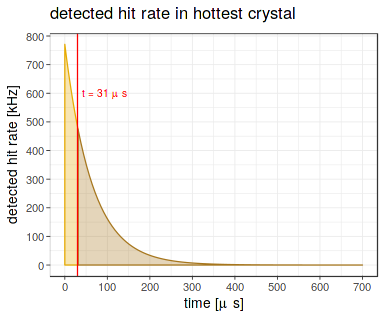

In [19]:
##
## hit rate in hottest crystal
##

##--- number of hist in fill for 
num.hits.crystal.max = hits.percrystal.perfill.from.rate.at.time(crystal.hit.rate.max)

ggplot(data.frame(x = c(0, 700)), aes(x = x)) +
  ggtitle(TeX("detected hit rate in hottest crystal")) +
  stat_function(fun = function(x) num.hits.crystal.max*1e-3/mudecay.tau.lab*exp(-x*1e-6/mudecay.tau.lab),
    xlim = c(0,31), geom = "area", fill=plot.cols[6], color=plot.cols[6], alpha=0.3) +
  stat_function(fun = function(x) num.hits.crystal.max*1e-3/mudecay.tau.lab*exp(-x*1e-6/mudecay.tau.lab),
    xlim = c(31,700), geom = "area", fill=plot.cols[7], color=plot.cols[7], alpha=0.3) +
  scale_x_continuous(name = TeX("time \\[$\\mu$s\\]"), breaks=pretty_breaks(10)) +
  scale_y_continuous(name = "detected hit rate [kHz]", limits=c(0,NA), breaks=pretty_breaks(10)) +
  coord_cartesian(xlim=c(0,700)) +
  geom_vline(xintercept=31, color="red") +
  annotate("text", label = as.character(TeX("t = 31 $\\mu$s")), x = 40, y = 600, hjust=0, color="red", parse = T) +
  ## scale_color_brewer(palette="Dark2") +
  ## scale_fill_brewer(palette="Dark2") +
  NULL
save.plot("crystal-hit-rate-hottest")

In [20]:
##--- detected muons per crystal per fill abover y threshold
mudecay.percrystal.perfill.abthr = mudecay.perfill.abthr / num.crystal
mudecay.percrystal.perfill.abthr.alltimes = mudecay.percrystal.perfill.abthr / mudecay.after.t.method.start.time

##--- detected muons per crystal per fill at all energies
mudecay.percrystal.perfill = mudecay.percrystal.perfill.abthr * mudecay.frac.E.detected.min / mudecay.frac.y.thr
mudecay.percrystal.perfill.alltimes = mudecay.percrystal.perfill / mudecay.after.t.method.start.time

cat("detected muon decays per crystal per fill\n")
cat("  after 31 mus:               ",
    sprintf("%.2f", mudecay.percrystal.perfill.abthr), "for y > 0.6, ",
    sprintf("%.2f", mudecay.percrystal.perfill), "for E_lab > 25 MeV")
cat("\n")

cat("  all times:                  ",
    sprintf("%.2f", mudecay.percrystal.perfill.abthr.alltimes), "for y > 0.6, ",
    sprintf("%.2f", mudecay.percrystal.perfill.alltimes), "for E_lab > 25 MeV")
cat("\n")

cat("  all times, hottest crystal: ",
    sprintf("%.2f", mudecay.percrystal.perfill.abthr.alltimes * crystal.hit.rate.max/crystal.hit.rate.mean),
        "for y > 0.6, ",
    sprintf("%.2f", mudecay.percrystal.perfill.alltimes * crystal.hit.rate.max/crystal.hit.rate.mean),
        "for E_lab > 25 MeV")
cat("\n")

detected muon decays per crystal per fill
  after 31 mus:                0.85 for y > 0.6,  2.59 for E_lab > 25 MeV
  all times:                   1.38 for y > 0.6,  4.21 for E_lab > 25 MeV
  all times, hottest crystal:  3.15 for y > 0.6,  9.61 for E_lab > 25 MeV


In [21]:
mudecay.detected.y.mean =
  integrate(function(y) y*mudecay.detected(y), lower=mudecay.E.detected.min/mudecay.E.max, upper=1)$value /
  mudecay.detected.norm
mudecay.detected.E.mean = mudecay.detected.y.mean * mudecay.E.max
cat(sprintf("mean energy of detected muon decays: %.2f GeV\n", mudecay.detected.E.mean))

mean energy of detected muon decays: 1.48 GeV


In [22]:
##
## effective energy of a burst of pulses compared to a single pulse for SiPM gain drop
##
burst.gain = function(N, pulse.dt=1e-6, tau.gaindrop = 10e-6) {
  ##
  ## Taylor expand numerator and denominator to 2nd order for pulse.dt / tau.gaindrop < 1e-4
  ## to avoid denominator pole
  ##
  ifelse(abs(pulse.dt/tau.gaindrop) < 1e-4,
        N - 1/2*(N^2 -N)*pulse.dt/tau.gaindrop / (1+1/2*pulse.dt/tau.gaindrop),
        (1-exp(-N*pulse.dt/tau.gaindrop)) / (1-exp(-pulse.dt/tau.gaindrop)))
}

file burst-gain-vs-burst-rep-time.png produced
file burst-gain-vs-burst-rep-time.pdf produced


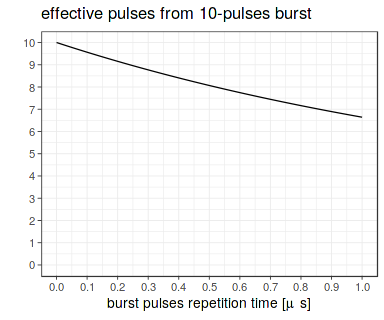

In [23]:
ggplot(data.frame(x = c(0, 1)), aes(x = x)) +
  ggtitle(TeX("effective pulses from 10-pulses burst")) +
  stat_function(fun = function(x) burst.gain(N=10, pulse.dt=x*1e-6, tau.gaindrop=10e-6)) +
  scale_x_continuous(name = TeX("burst pulses repetition time \\[$\\mu$s\\]"), breaks=pretty_breaks(10)) +
  scale_y_continuous(name = "", limits=c(0,NA), breaks=pretty_breaks(10)) +
  #coord_cartesian(xlim=c(0, 1e-5)) +
  NULL
save.plot("burst-gain-vs-burst-rep-time")

In [24]:
##
## digitized plot on gain drop
## obtained with flight simulator corresponding to 2x expected data rate
##
sipm.gain.df = read.csv("gain-resp-long-ed.csv")

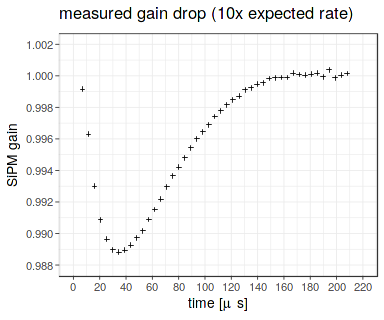

In [25]:
ggplot(sipm.gain.df, aes(x = time, y = gain)) +
  ggtitle(TeX("measured gain drop (10x expected rate)")) +
  geom_point(shape=3) +
  scale_x_continuous(name = TeX("time \\[$\\mu$s\\]"), limits=c(0,220), breaks=pretty_breaks(10)) +
  scale_y_continuous(name = "SiPM gain", limits=c(NA,1.001), breaks=pretty_breaks(10)) +
  coord_cartesian(ylim=c(0.988,1.002)) +
  NULL
## save.plot("")

In [26]:
##
## SiPM gain theory model
## - exponentially decaying hit rate
## - each hit causes gain drop, with size decaying exponentially with time
## - gain drop = convolution of hit rate with single-hit gain drop
##
sipm.gain = function(t, A = 0.95e3, tau.mu = mudecay.tau.lab, tau.gain = 20e-6) {
  1 - A * (tau.mu * tau.gain) / (tau.mu - tau.gain) *(exp(-t/tau.mu) - exp(-t/tau.gain))
}

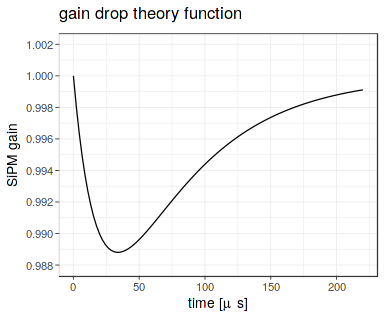

In [27]:
ggplot(data.frame(x = c(0, 200)), aes(x = x)) +
  ggtitle(TeX("gain drop theory function")) +
  stat_function(fun = function(t) sipm.gain(t*1e-6)) +
  scale_x_continuous(name = TeX("time \\[$\\mu$s\\]"), limits=c(0,220), breaks=pretty_breaks(7)) +
  scale_y_continuous(name = "SiPM gain", limits=c(NA,1.001), breaks=pretty_breaks(7)) +
  coord_cartesian(ylim=c(0.988,1.002)) +
  NULL
##save.plot("")

In [28]:
head(sipm.gain.df)

time,gain
6.886238,0.9991581
11.466333,0.9963065
16.047772,0.9929909
20.626022,0.9908660
25.193274,0.9896375
29.772252,0.9889772


In [29]:
## sipm.gain = function(t, A = 0.95e3, tau.mu = mudecay.tau.lab, tau.gain = 20e-6) {
sipm.gain.fitfun = function(time, A=0.95e3, tau.gain=20e-6) {
    sipm.gain(t=time*1e-6, A=A, tau.gain=tau.gain)
}
fit.rc <- nls(gain~sipm.gain.fitfun(time, A, tau.gain), data=sipm.gain.df, start=list(A=0.95e3, tau.gain=20e-6))
fit.rc

Nonlinear regression model
  model: gain ~ sipm.gain.fitfun(time, A, tau.gain)
   data: sipm.gain.df
        A  tau.gain 
9.289e+02 1.640e-05 
 residual sum-of-squares: 0.000103

Number of iterations to convergence: 46 
Achieved convergence tolerance: 9.488e-06

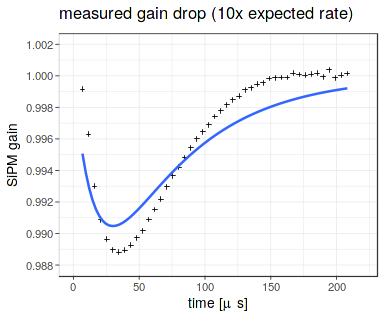

In [30]:
ggplot(sipm.gain.df, aes(x = time, y = gain)) +
  ggtitle(TeX("measured gain drop (10x expected rate)")) +
  geom_point(shape=3) +
  geom_smooth(method = 'nls', formula = y ~ sipm.gain.fitfun(x, A, tau.gain),
              method.args=list(start = c(A=0.95e3, tau.gain = 20e-6)), se = FALSE) +
  scale_x_continuous(name = TeX("time \\[$\\mu$s\\]"), limits=c(0,220), breaks=pretty_breaks(7)) +
  scale_y_continuous(name = "SiPM gain", limits=c(NA,1.001), breaks=pretty_breaks(7)) +
  coord_cartesian(ylim=c(0.988,1.002), xlim=c(0,220)) +
  NULL

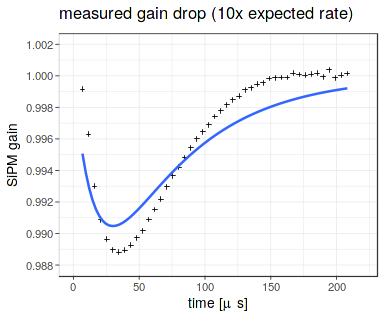

In [31]:
tau.mu = mudecay.tau.lab
ggplot(data.frame(sipm.gain.df, weight=1/(3/100*sipm.gain.df$gain)), aes(x = time, y = gain)) +
  ggtitle(TeX("measured gain drop (10x expected rate)")) +
  geom_point(shape=3) +
  geom_smooth(method = 'nls', data=data.frame(sipm.gain.df),
              formula = y ~ 1 - A * (tau.mu * tau.gain) / (tau.mu - tau.gain) * 
                        (exp(-x*1e-6/tau.mu) - exp(-x*1e-6/tau.gain)),
              method.args=list(start = c(A=0.95e3, tau.gain=20e-6)), se = FALSE) +
  scale_x_continuous(name = TeX("time \\[$\\mu$s\\]"), limits=c(0,220), breaks=pretty_breaks(7)) +
  scale_y_continuous(name = "SiPM gain", limits=c(NA,1.001), breaks=pretty_breaks(7)) +
  coord_cartesian(ylim=c(0.988,1.002), xlim=c(0,220)) +
  NULL
rm(tau.mu)